In [22]:
from keras.models import Model
from keras.layers import Flatten,Dense
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plot
from glob import glob

#data Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

we will provide our image size i.e 224 x 224 this is a fixed-size for VGG16 architecture. 3 signifies that we are working with RGB type of images. Then we will provide our training and testing data path.

In [23]:
IMAGESHAPE = [224, 224, 3] 
training_data = '/Users/dammy/Downloads/chest_xray/train'
testing_data = '/Users/dammy/Downloads/chest_xray/test'

Next I displayed some normal and pneumonia images to just have a look at how much different they look from the naked eye.

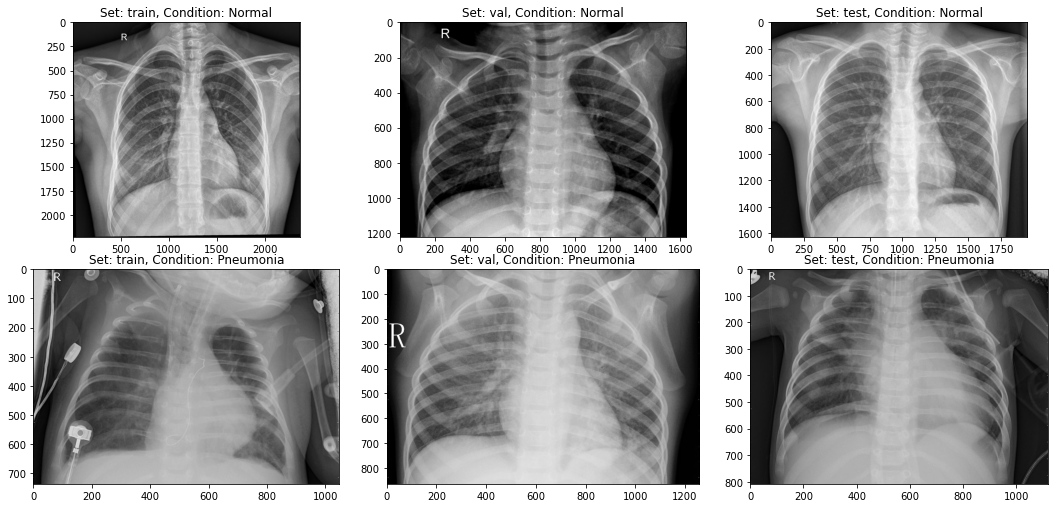

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
input_path = '/Users/dammy/Downloads/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

we will import our VGG16 model. While importing we will use the weights of the imageNet & include_top=False signifies that we do not want to classify 1000 different categories present in imageNet our problem is all about two categories Pneumonia and Normal that’s why we are just dropping the first and last layers then we will just design our own layers and add it into VGG16.

In [13]:
vgg_model = VGG16(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

2022-11-05 22:49:33.530187: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-05 22:49:33.666448: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd001daa070 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-05 22:49:33.667739: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


58892288/58889256 [==============================] - 356s 6us/step


After importing VGG16 model, we have to make this important change. By using the for loop iterating over all layers and setting the trainable as False, so that all the layers would not be trained.

In [14]:
for each_layer in vgg_model.layers:
    each_layer.trainable = False

We will try to see how many classes are present in our train dataset to understand how many output labels we should have.

In [12]:
classes = glob('/Users/dammy/Downloads/chest_xray/train/*') 

In [20]:
print(classes)

['/Users/dammy/Downloads/chest_xray/train/PNEUMONIA', '/Users/dammy/Downloads/chest_xray/train/NORMAL']


As we deleted the first and the last columns in the previous step, We will just make a flattened layer and finally we just add our last layer with a softmax activation function. len(classes) indicate how many categories we have in our output layer. 

In [16]:

flatten_layer = Flatten()(vgg_model.output)
prediction = Dense(len(classes), activation='softmax')(flatten_layer)

Now we will combine the VGG output and prediction, this all together will create a model. When we check the model summary we can observe that the last layer have only two categories.

In [17]:

final_model = Model(inputs=vgg_model.input, outputs=prediction) 
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Now we will compile our model using adam optimizer and optimization metric as accuracy.

In [18]:
final_model.compile( 
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

After compiling the model, we have to import our dataset to Keras using ImageDataGenerator in Keras. For creating additional features we use metrics like rescale, shear_range, zoom_range these will help us in the training and testing phases.

In [15]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
testing_datagen = ImageDataGenerator(rescale =1. / 255)

Now we will insert the images using flow_from_directory() function. Make sure that here we have to pass the same image size as we initiated earlier. Batch size 4 indicates that at once 4 images will be given for training. Class_mode is Categorical i.e either Pneumonia or Not Pneumonia.

In [16]:
training_set = train_datagen.flow_from_directory('/Users/dammy/Downloads/chest_xray/train', 
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [17]:
test_set = testing_datagen.flow_from_directory('/Users/dammy/Downloads/chest_xray/test',
                                               target_size = (224, 224),
                                               batch_size = 4,
                                               class_mode = 'categorical')

Found 624 images belonging to 2 classes.


Finally, we are fitting the model using fit_generator() function and passing all the necessary details regarding our training and testing dataset as arguments.

In [23]:
fitted_model = final_model.fit_generator( 
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
1304/1304 [==============================] - 2621s 2s/step - loss: 0.2808 - accuracy: 0.9210 - val_loss: 0.0014 - val_accuracy: 0.8638
Epoch 2/5
1304/1304 [==============================] - 7323s 6s/step - loss: 0.2781 - accuracy: 0.9438 - val_loss: 1.7968e-04 - val_accuracy: 0.9279
Epoch 3/5
1304/1304 [==============================] - 19428s 15s/step - loss: 0.2444 - accuracy: 0.9528 - val_loss: 0.0000e+00 - val_accuracy: 0.8926
Epoch 4/5
1304/1304 [==============================] - 9435s 7s/step - loss: 0.2350 - accuracy: 0.9580 - val_loss: 0.0010 - val_accuracy: 0.9087
Epoch 5/5
1304/1304 [==============================] - 2269s 2s/step - loss: 0.2219 - accuracy: 0.9578 - val_loss: 2.4088 - val_accuracy: 0.9199


In [24]:
final_model.save('our_model.h5')

In [85]:
from keras_preprocessing import image
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
import numpy as np
model=load_model('our_model.h5') #Loading our model
img=image.load_img('/Users/dammy/Downloads/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',target_size=(224,224))
imagee=image.img_to_array(img) #Converting the X-Ray into pixels
imagee=np.expand_dims(imagee, axis=0)
img_data=preprocess_input(imagee)
prediction=model.predict(img_data)
result = int(prediction[0][0])
# if prediction[0][0]>prediction[0][1]: #Printing the prediction of model.
# 	print('Person is safe.')
# else:
# 	print('Person is affected with Pneumonia.')
if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Result is Normal")
print(f'Predictions: {result}')


Result is Normal
Predictions: 1


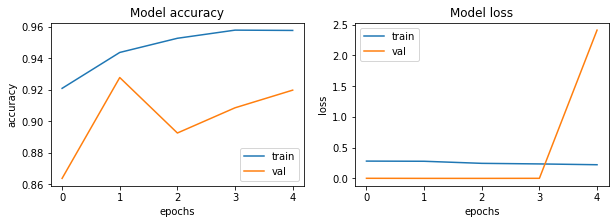

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(fitted_model.history[met])
    ax[i].plot(fitted_model.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

So far so good. The model is converging which can be observed from the decrease in loss and validation loss with epochs. Also it is able to reach 90% validation accuracy in just 5 epochs.

In [35]:
final_model.evaluate(test_set)

156/156 [==============================] - 698s 4s/step


[1.648033139645122e-05, 0.9198718070983887]

In [8]:
# I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
import cv2
import os

test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (224, 224))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)



[[200  34]
 [ 15 375]]
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       234
           1       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



<AxesSubplot:>

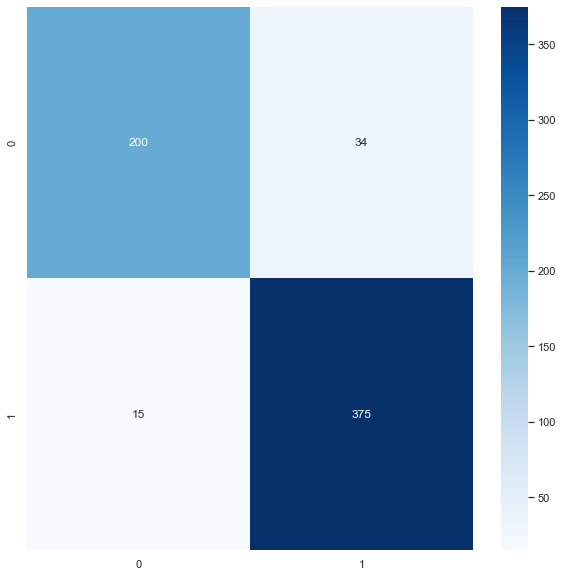

In [84]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
predictions = model.predict(test_data)

y_pred = np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, y_pred))
cm = confusion_matrix(test_labels, y_pred)
report = classification_report(test_labels, y_pred)
print(report)
sns.set(rc={"figure.figsize":(10, 10)})
sns.heatmap(cm, cmap= "Blues", annot=True, fmt='', linecolor = 'black')
